<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/stackExchange_NN_Multilabelclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install torchtext --upgrade --q
  !pip install torchmetrics --q
  !pip install -quiet torch-lr-finder --q
  !pip install wandb --q --upgrade

  basepath = '/content/drive/My Drive/NLP' 
  sys.path.append('/content/drive/My Drive/NLP/custom-functions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [3]:
#Importing the required libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics
from torchmetrics.classification import MultilabelF1Score, MultilabelHammingDistance
from torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance

import joblib
#import swifter
import ast
import wandb

from types import SimpleNamespace
from functools import partial
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer as mlb


In [4]:
#Defined the google drive folders for accessing/saving models related files
embeddings_folder = Path(basepath)/ 'assignment7/WordEmbeddings'
data_folder = Path(basepath)/ 'assignment7/MultiLabel_Classification'
model_saving_folder = Path(basepath)/ 'assignment7/MultiLabel_Classification'

In [5]:
data_cleaned = data_folder/ "df_multilabel_hw_cleaned.joblib"
stackExchange_dataset = joblib.load(data_cleaned)

In [6]:
X = stackExchange_dataset['cleaned_text'].values
y = stackExchange_dataset['Tag_Number'].values

In [7]:
!pip install swifter -qq

In [8]:
import swifter
import ast
stackExchange_dataset['Tag_Number_list'] = stackExchange_dataset['Tag_Number'].swifter.apply(lambda x: ast.literal_eval(x))

Pandas Apply:   0%|          | 0/47427 [00:00<?, ?it/s]

In [9]:
y_final = stackExchange_dataset['Tag_Number_list'].values

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer as mlb
y_stackExchange_encoding = mlb().fit_transform(y_final)

In [11]:
from sklearn.model_selection import train_test_split
X_sExchange_train, X_valid_test, y_sExchange_train, y_valid_test = train_test_split(X, y_stackExchange_encoding, test_size=0.4, random_state=42)
X_sExchange_valid, X_sExchange_test, y_sExchange_valid, y_sExchange_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=42)

In [12]:
from gensim.models import KeyedVectors
pretrained_sExchange_file = str(embeddings_folder/ "model_stackExchange_CBOW.bin")
sExchange_vectors = KeyedVectors.load(pretrained_sExchange_file)

In [13]:
!pip install torch_lr_finder -qq

In [14]:
from torch_lr_finder import LRFinder
from Trainer_v4 import Trainer
from data_preparation_HW7 import * 

In [15]:
from ff_sequential_model import MLPCustom
#from ff_sequential_model_v1 import MLPCustom

In [16]:
#Creating training dataset with subset 
import random
Trainer.set_seed()
sExchange_trainset = CustomDataset(X_sExchange_train, y_sExchange_train)
se_train_subset_indices = random.sample(range(0, len(sExchange_trainset)), 500)
se_train_subset = torch.utils.data.Subset(sExchange_trainset, se_train_subset_indices)
se_vocab = get_vocab(sExchange_trainset, min_freq=2)

In [17]:
type(se_vocab), se_vocab['debug']

(torchtext.vocab.vocab.Vocab, 4164)

In [18]:
pretrained_sExchange_file = str(embeddings_folder/ "model_stackExchange_CBOW.bin")
sExchange_vectors = KeyedVectors.load(pretrained_sExchange_file)

In [19]:
pretrained_weights, words_found, words_not_found = get_pretrained_weights(
    vocab = se_vocab,
    pretrained_vectors = sExchange_vectors,
    embedding_dim = 300, #updated from 300 to 150
)

In [20]:
pretrained_weights.shape

torch.Size([90287, 300])

In [21]:
type(pretrained_weights), words_found, words_not_found

(torch.Tensor, 14664, 75623)

Initialining all required HyperParameters 

In [81]:
hyperparameters = SimpleNamespace(
# for model
    EMBED_DIM=300,
    VOCAB_SIZE=len(se_vocab),
    OUTPUT_DIM=10,
    HIDDEN_SIZES_LIST=[],
    DPROB_LIST=[],
    NON_LINEARITY=nn.SELU(),
    BATCH_NORM=False,
    
    # for optimizer
    OPTIMIZER="SGD",
    MOMENTUM=0,
    NESTEROV=False,
    
    # for training
    INITIALIZATION="default",
    EPOCHS=20,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001,
    DATASET="STACKEXCHANGE",
    ARCHITECTURE="emdbag_linear",
    
    # Schedulers
    SCHEDULER="None",
)

Specifying run name & folder

In [82]:
#Defining the variables
project_name = "StackExchange NN architecture"
run_name="Task3a experiment4"
run_folder = model_saving_folder / run_name
run_folder.mkdir(exist_ok=True)
log_frequency = 5

Modifying Hyperparameters for Run

In [83]:
# run 1 - based on default initialization
# Notes: Final Learning rate was set to 1

# run 2
hyperparameters.HIDDEN_SIZES_LIST = [200]
hyperparameters.DPROB_LIST = [0]
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# Notes : Final Learning rate was set to 1.18

# run 3
hyperparameters.OPTIMIZER = "Adam"
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# Notes : Final Learning rate was set to 0.006

# run 4
hyperparameters.HIDDEN_SIZES_LIST = [200] + [200]
hyperparameters.DPROB_LIST = [0] + [0]
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# Notes : Final Learning rate was set to 0.02

# run 5
#hyperparameters.INITIALIZATION = 'kaiming'
#hyperparameters.NON_LINEARITY = nn.ReLU()
#hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# Notes : Final Learning rate was set to 0.02

# run 6
#hyperparameters.HIDDEN_SIZES_LIST = [400] 
#hyperparameters.DPROB_LIST = [0] 
#hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 0.02

Configuring the trainer 

In [84]:
#Set the seed value 
Trainer.set_seed()

se_collate_fn = partial(collate_batch, vocab=se_vocab)

In [85]:
type(se_collate_fn)

functools.partial

In [86]:
#Data Loader
se_train_loader, _ = get_loaders(trainset=sExchange_trainset, validset=None, 
                                         batch_size_=hyperparameters.BATCH_SIZE,
                                         collate_fn=se_collate_fn)

se_loss_function = nn.BCEWithLogitsLoss()
stackExchange_model = MLPCustom(hyperparameters.EMBED_DIM,
                                hyperparameters.VOCAB_SIZE,
                                hyperparameters.HIDDEN_SIZES_LIST,
                                hyperparameters.DPROB_LIST, 
                                hyperparameters.OUTPUT_DIM, 
                                hyperparameters.NON_LINEARITY,
                                hyperparameters.BATCH_NORM,)
                                # use_pre_trained_weights = hyperparameters.USE_PRE_TRAINED_WEIGHTS,
                                # pretrained_weights = pretrained_weights,
                                # freeze_pretrained = hyperparameters.FREEZE_PRETRAINED)
def init_weights(m):
  if type(m)=="nn.Linear":
    torch.nn.init.kaiming_normal_(m.weight)
    torch.nn.init.zeros_(nn.bias)

#Apply initialization to all modules
if hyperparameters.INITIALIZATION == 'kaiming':
  stackExchange_model.apply(init_weights)


#Defining optimizer
def get_optimizer():
  if hyperparameters.OPTIMIZER == 'SGD':
    optimizer = torch.optim.SGD(
        stackExchange_model.parameters(),
        lr = hyperparameters.LEARNING_RATE,
        momentum = hyperparameters.MOMENTUM,
        nesterov = hyperparameters.NESTEROV,
    )
  else:
    optimizer = torch.optim.Adam(
        stackExchange_model.parameters(),
        lr = hyperparameters.LEARNING_RATE
    )
  return optimizer

sExchange_optimizer = get_optimizer()
sExchange_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [87]:
sExchange_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [88]:
stackExchange_model

MLPCustom(
  (non_linearity): SELU()
  (embedding): EmbeddingBag(90287, 300, mode='mean')
  (module_list): ModuleList(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): SELU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): SELU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)

Trainer

In [89]:
sEXchange_trainer = Trainer(
    model=stackExchange_model, optimizer=sExchange_optimizer, 
    criterion=se_loss_function,
    device=sExchange_device
)
sEXchange_trainer.set_loaders(se_train_loader)

Learning Rate Finder

In [90]:
type(se_train_loader)

torch.utils.data.dataloader.DataLoader

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.54E-03


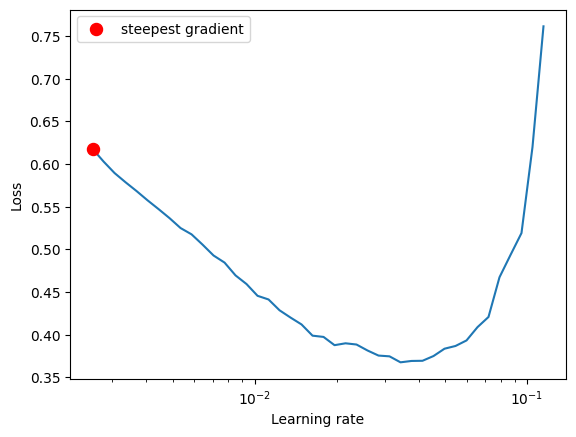

In [91]:
#sEXchange_trainer.lr_finder_range_test(sEXchange_trainer.se_train_loader)
sEXchange_trainer.lr_finder_range_test(se_train_loader)

In [92]:
hyperparameters.LEARNING_RATE = 0.003

Set trainer based on hyperparameters

In [93]:
#Resetting optimizer
sEXchange_trainer.set_optimizer(get_optimizer())

#Setting metric 
se_train_metric = MultilabelHammingDistance(num_labels=10)
sEXchange_trainer.set_metric(se_train_metric.to(sExchange_device))


In [94]:
#Setting wandb 
sEXchange_trainer.set_wandb(
    project_name = project_name,
    run_name = run_name,
    config = hyperparameters,
    log_batch=True, 
    log_frequency=log_frequency
)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [95]:
sEXchange_trainer.learning_rates

[0.003]

Sanity Check

In [96]:
sEXchange_trainer.sanity_check(num_classes=2)

Actual loss: 0.6937311467539985
Expected Theoretical loss: 0.6931471805599453


In [ ]:
sEXchange_trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)

Validation loader is not set. The trainer will only execute training Loop
Not saving any checkpoint
Epoch 1/20 - Train Loss: 0.1525, Train Metric: 0.0570, Train Time: 0:00:40.088964
Current Learning rate is 0.003

Epoch 2/20 - Train Loss: 0.0843, Train Metric: 0.0297, Train Time: 0:00:41.596526
Current Learning rate is 0.003

Epoch 3/20 - Train Loss: 0.0571, Train Metric: 0.0203, Train Time: 0:00:41.275981
Current Learning rate is 0.003

Epoch 4/20 - Train Loss: 0.0423, Train Metric: 0.0150, Train Time: 0:00:39.960548
Current Learning rate is 0.003

Epoch 5/20 - Train Loss: 0.0317, Train Metric: 0.0113, Train Time: 0:00:39.910247
Current Learning rate is 0.003

Epoch 6/20 - Train Loss: 0.0240, Train Metric: 0.0085, Train Time: 0:00:39.355826
Current Learning rate is 0.003

Epoch 7/20 - Train Loss: 0.0221, Train Metric: 0.0076, Train Time: 0:00:39.712406
Current Learning rate is 0.003



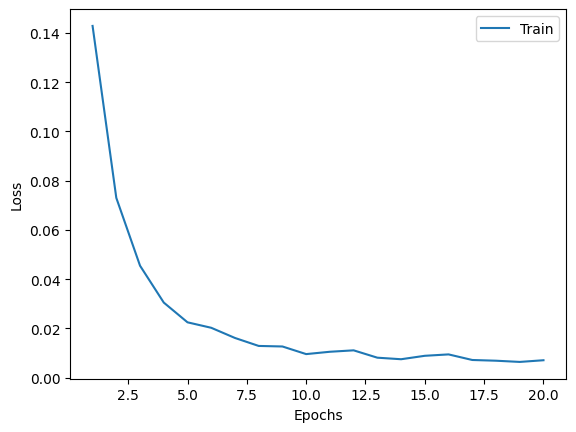

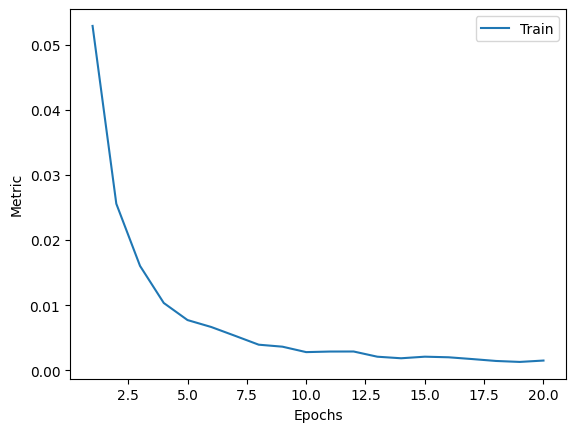

In [79]:
sEXchange_trainer.plot_history()

Finish Run

In [80]:
wandb.finish()

train_epoch_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_epoch_metric,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_epoch_loss,0.0071
train_epoch_metric,0.00148
